# Load packages

In [0]:
# trimming related
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import re, string
from pprint import pprint
import time


# Link to GDrive

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
if 2==1:
  # 2. Create & upload a file text file.
  uploaded = drive.CreateFile({'title': 'Sample upload.txt'})
  uploaded.SetContentString('Sample upload file content')
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [0]:
#https://drive.google.com/open?id=1lcBs3kpCY3yjPlvVHw7-Gk1Rd1JYzxxj

if 1==1:
  #2. Get the file
  downloaded = drive.CreateFile({'id':'1lcBs3kpCY3yjPlvVHw7-Gk1Rd1JYzxxj'}) # replace the id with id of file you want to access
  downloaded.GetContentFile('combined_trainingdata_20181108.tsv')  

  #3. Read file as panda dataframe
  import pandas as pd
  df = pd.read_csv('combined_trainingdata_20181108.tsv',sep='\t') 
  df.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Verify data

In [0]:
df.shape

(961399, 11)

In [0]:
df.head(2)

index          COMPLAINT_ID        CITY COMPLAINT DATE            DEPT_311  \
0      0       US_CHICAGO_1725  US_CHICAGO     10/03/2011  health_environment   
1      1  US_CHICAGO_600301602  US_CHICAGO     07/14/2017  health_environment   

                           CODE_311 CATEGORY_MAIN         CATEGORY_SUB  \
0  permits issued by doe work order   environment  environment_general   
1        illegal dumping work order   environment  environment_dumping   

                                         COMPLAINT_1  \
0  QUESTIONABLE BUSINESS PRACTICES REGARDING OILS...   
1  CONSTRUCTION/DEMOLITION DEBRIS DUMPED IN BACK ...   

                                         COMPLAINT_2  \
0  [INSPECTION LOG #: 1723 03-OCT-11 18:55:00] TH...   
1  [INSPECTION LOG #: 3439804 14-JUL-17 09:45:00]...   

                                           complaint  
0  questionable business practices regarding oils...  
1  constructiondemolition debris dumped back yard...

In [0]:
model_data=df[['CATEGORY_MAIN','CATEGORY_SUB','complaint']]

# Basic Modeling

In [0]:
# Load packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score

%matplotlib inline

** drop any category with less than 100 occurances**

In [0]:
model_data.dropna(axis=0,subset=['complaint'],inplace=True)
model_data=model_data[model_data.groupby('CATEGORY_SUB').CATEGORY_MAIN.transform(len) > 99]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
y_main= model_data['CATEGORY_MAIN']
y_sub= model_data['CATEGORY_SUB']
x= model_data['complaint']

count_vect = CountVectorizer()
x_counts = count_vect.fit_transform(x)
tfidf_transformer = TfidfTransformer()
x_tfidf = tfidf_transformer.fit_transform(x_counts)

In [0]:
#main categories
x_train_main, x_test_main, y_train_main, y_test_main = train_test_split( x_tfidf, y_main, test_size=0.2, random_state=412, stratify=y_main)

#sub categories
x_train_sub, x_test_sub, y_train_sub, y_test_sub = train_test_split( x_tfidf, y_sub, test_size=0.2, random_state=412, stratify=y_sub)

## Naive Bayes

In [0]:
modelNB_sub = MultinomialNB().fit(x_train_sub, y_train_sub)

In [0]:
display(modelNB_sub.predict(count_vect.transform(["fire escape"]))[0])
display(modelNB_sub.predict(count_vect.transform(["trash left in emp ty lot"]))[0])
display(modelNB_sub.predict(count_vect.transform(["broken window in abandoned house"]))[0])
display(modelNB_sub.predict(count_vect.transform(["graffiti"]))[0])

'housing_general'

'environment_garbage_collection'

'environment_abandoned_vehicle'

'vandalism_graffiti'

In [0]:
y_predict_NB_sub=modelNB_sub.predict(x_test_sub)

In [0]:
print('accuracy score:',accuracy_score(y_test_sub, y_predict_NB_sub, normalize=True, sample_weight=None))

print(classification_report(y_test_sub, y_predict_NB_sub))

accuracy score: 0.6994261753520724
                                 precision    recall  f1-score   support

        environemnt_dead_animal       0.00      0.00      0.00        54
     environment_abandoned_site       1.00      0.17      0.29       833
  environment_abandoned_vehicle       0.77      0.71      0.74      5043
      environment_air_pollution       0.68      0.91      0.78      3551
           environment_asbestos       1.00      0.04      0.07       542
        environment_dead_animal       0.93      0.59      0.73      1972
            environment_dumping       0.59      0.53      0.56      7219
 environment_garbage_collection       0.75      0.98      0.85     47408
            environment_general       0.95      0.06      0.11      1511
 environment_hazardous_material       0.92      0.20      0.32      1151
             environment_litter       0.98      0.15      0.26      2982
         environment_overgrowth       0.56      0.91      0.69     15871
          envir

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## SVM

In [0]:
modelsvc_sub = LinearSVC()
modelsvc_sub.fit(x_train_sub, y_train_sub)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [0]:
display(modelsvc_sub.predict(count_vect.transform(["fire escape"]))[0])
display(modelsvc_sub.predict(count_vect.transform(["trash left in empty lot"]))[0])
display(modelsvc_sub.predict(count_vect.transform(["broken window in abandoned house"]))[0])
display(modelsvc_sub.predict(count_vect.transform(["graffiti"]))[0])

'fire_general'

'environment_garbage_collection'

'housing_general'

'vandalism_graffiti'

In [0]:
y_predict_svc_sub = modelsvc_sub.predict(x_test_sub)

In [0]:


y_predict_svc_sub = pd.DataFrame(y_predict_svc_sub, dtype='str',columns=['predict_SUB'])['predict_SUB'].map(lambda x: x.replace('environemnt','environment'))

In [0]:
'environemnt_dead_animal'.replace('environemnt','environment')

'environment_dead_animal'

In [0]:
print('accuracy score:',accuracy_score(y_test_sub, y_predict_svc_sub, normalize=True, sample_weight=None))

print(classification_report(y_test_sub, y_predict_svc_sub))

accuracy score: 0.8115742980662681
                                 precision    recall  f1-score   support

        environemnt_dead_animal       0.00      0.00      0.00        54
     environment_abandoned_site       0.70      0.53      0.60       833
  environment_abandoned_vehicle       0.76      0.85      0.80      5043
      environment_air_pollution       0.85      0.89      0.87      3551
           environment_asbestos       0.91      0.94      0.93       542
        environment_dead_animal       0.85      0.93      0.89      1972
            environment_dumping       0.67      0.64      0.65      7219
 environment_garbage_collection       0.89      0.96      0.92     47408
            environment_general       0.65      0.41      0.50      1511
 environment_hazardous_material       0.78      0.73      0.76      1151
             environment_litter       0.69      0.50      0.58      2982
         environment_overgrowth       0.78      0.88      0.82     15871
          envir

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### let's convert to main category 
**and see how they do**

In [0]:
y_predict_svc_sub[:2]

0    environment_garbage_collection
1           environment_dead_animal
Name: predict_SUB, dtype: object

In [0]:
y_dummy=y_test_sub.map(lambda x: x.split('_')[0])


predict_dummy= y_predict_svc_sub.map(lambda x: x.split('_')[0])

In [0]:
print('accuracy score:',accuracy_score(y_dummy, predict_dummy, normalize=True, sample_weight=None))

print(classification_report(y_dummy, predict_dummy))

accuracy score: 0.8746794021402671
                precision    recall  f1-score   support

   environemnt       0.00      0.00      0.00        54
   environment       0.92      0.96      0.94     99855
          fire       0.71      0.72      0.72      1080
    governance       0.57      0.41      0.48     10278
       housing       0.78      0.76      0.77     10367
infrastructure       0.76      0.73      0.74      7108
      planning       0.86      0.71      0.78      7515
  publichealth       0.91      0.90      0.91      5215
   publicorder       0.74      0.69      0.71      3441
        street       0.88      0.89      0.88     39904
     vandalism       0.89      0.90      0.89      7402

   avg / total       0.87      0.87      0.87    192219



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


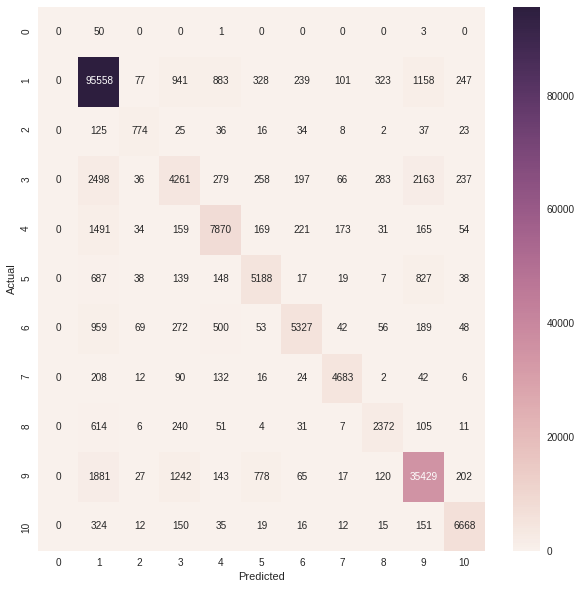

0.8746794021402671

In [0]:
#with MAIN classes
cm_svc = confusion_matrix(y_dummy, predict_dummy)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_svc, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
display(accuracy_score(y_dummy, predict_dummy, normalize=True, sample_weight=None))

## XGBoost

In [0]:
from xgboost import XGBClassifier 

In [0]:
model_xgb = XGBClassifier()
model_xgb.fit(x_train_sub, y_train_sub)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [0]:
print(model_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [0]:
y_predict_xgb_sub = model_xgb.predict(x_test_sub)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [0]:


y_predict_xgb_sub = pd.DataFrame(y_predict_xgb_sub, dtype='str',columns=['predict_SUB'])['predict_SUB'].map(lambda x: x.replace('environemnt','environment'))

In [0]:
print('accuracy score:',accuracy_score(y_test_sub, y_predict_xgb_sub, normalize=True, sample_weight=None))

print(classification_report(y_test_sub, y_predict_xgb_sub))

accuracy score: 0.7414979788678538
                                 precision    recall  f1-score   support

        environemnt_dead_animal       0.00      0.00      0.00        54
     environment_abandoned_site       0.79      0.51      0.62       833
  environment_abandoned_vehicle       0.75      0.71      0.73      5043
      environment_air_pollution       0.86      0.82      0.84      3551
           environment_asbestos       0.90      0.92      0.91       542
        environment_dead_animal       0.79      0.91      0.85      1972
            environment_dumping       0.72      0.50      0.59      7219
 environment_garbage_collection       0.63      0.97      0.77     47408
            environment_general       0.78      0.34      0.47      1511
 environment_hazardous_material       0.80      0.54      0.64      1151
             environment_litter       0.73      0.40      0.52      2982
         environment_overgrowth       0.78      0.82      0.80     15871
          envir

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [0]:

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=10000)
Xall=tfidf_vect.fit_transform(model_data['complaint'])


<1x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 41 stored elements in Compressed Sparse Row format>

<2x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 6 stored elements in Compressed Sparse Row format>

## Classification Report as dataframe

In [0]:
# minor mod from https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format Raul

from  sklearn.metrics import precision_recall_fscore_support

def pandas_classification_report(y_true, y_pred,testname):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = [testname+'_precision', testname+'_recall', testname+'_f1-score', testname+'_support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc[testname+'_support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['avg / total'] = avg

    return class_report_df.T

In [0]:
# minor mod from https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format Kam Sen
from io import StringIO

def report_to_df(report,testname):
    report = re.sub(r" +", " ", report).replace("avg / total", "avg/total").replace("\n ", "\n")
    #report_df = pd.read_csv(StringIO("Classes" + report), sep=' ', index_col=0)  
    report_df = pd.read_csv(StringIO(report), sep=' ', index_col=0) 
    report_df.columns=[testname+'_precision', testname+'_recall', testname+'_f1-score', testname+'_support']
    return(report_df)


In [0]:
report_to_df(classification_report(y_test_sub, y_predict_svc_sub),'svm')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


svm_precision  svm_recall  svm_f1-score  \
environemnt_dead_animal                   0.00        0.00          0.00   
environment_abandoned_site                0.70        0.53          0.60   
environment_abandoned_vehicle             0.76        0.85          0.80   
environment_air_pollution                 0.85        0.89          0.87   
environment_asbestos                      0.91        0.94          0.93   
environment_dead_animal                   0.85        0.93          0.89   
environment_dumping                       0.67        0.64          0.65   
environment_garbage_collection            0.89        0.96          0.92   
environment_general                       0.65        0.41          0.50   
environment_hazardous_material            0.78        0.73          0.76   
environment_litter                        0.69        0.50          0.58   
environment_overgrowth                    0.78        0.88          0.82   
environment_recycling                     0.93        0.89          0.91   
fire_equipment_broken                     0.55        0.53          0.54   
fire_general                              0.73        0.75          0.74   
fire_risks                                0.50        0.10          0.16   
governance_general                        0.46        0.30          0.36   
governance_parks_and_rec                  0.54        0.39          0.45   
governance_signage                        0.63        0.62          0.62   
housing_general                           0.75        0.75          0.75   
housing_health_code                       0.59        0.51          0.55   
housing_mold                              0.82        0.86          0.84   
housing_pests                             0.55        0.19          0.28   
housing_safety                            0.62        0.53          0.57   
infrastructure_general                    0.73        0.75          0.74   
infrastructure_power                      0.93        0.75          0.83   
infrastructure_water                      0.61        0.50          0.55   
infrastructure_water_repair               0.72        0.62          0.66   
planning_construction                     0.68        0.25          0.37   
planning_general                          0.79        0.57          0.66   
planning_unsafe_environment               0.92        0.91          0.91   
publichealth_animal                       0.59        0.30          0.40   
publichealth_animal_feces                 0.62        0.64          0.63   
publichealth_general                      0.97        0.93          0.95   
publichealth_pests                        0.79        0.85          0.82   
publichealth_restaurant_hygiene           0.90        0.98          0.94   
publicorder_general                       0.53        0.45          0.49   
publicorder_noise_complaint               0.91        0.93          0.92   
street_cleaning                           0.76        0.62          0.68   
street_drainage                           0.51        0.41          0.45   
street_general                            0.50        0.23          0.31   
street_lighting                           0.91        0.94          0.93   
street_parking                            0.64        0.63          0.63   
street_repair                             0.84        0.91          0.87   
street_roadkill                           0.83        0.34          0.48   
street_sewar                              0.72        0.78          0.75   
street_sidewalk                           0.63        0.62          0.62   
street_slippery                           0.84        0.88          0.86   
street_urgent_repair                      0.78        0.81          0.79   
vandalism_general                         0.82        0.40          0.53   
vandalism_graffiti                        0.89        0.91          0.90   
avg/total                                 0.80        0.81          0.80   

    

In [0]:
report_to_df(classification_report(y_test_sub, y_predict_NB_sub),'NB')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


NB_precision  NB_recall  NB_f1-score  \
environemnt_dead_animal                  0.00       0.00         0.00   
environment_abandoned_site               1.00       0.17         0.29   
environment_abandoned_vehicle            0.77       0.71         0.74   
environment_air_pollution                0.68       0.91         0.78   
environment_asbestos                     1.00       0.04         0.07   
environment_dead_animal                  0.93       0.59         0.73   
environment_dumping                      0.59       0.53         0.56   
environment_garbage_collection           0.75       0.98         0.85   
environment_general                      0.95       0.06         0.11   
environment_hazardous_material           0.92       0.20         0.32   
environment_litter                       0.98       0.15         0.26   
environment_overgrowth                   0.56       0.91         0.69   
environment_recycling                    0.97       0.60         0.74   
fire_equipment_broken                    0.00       0.00         0.00   
fire_general                             0.97       0.17         0.29   
fire_risks                               0.00       0.00         0.00   
governance_general                       0.29       0.42         0.34   
governance_parks_and_rec                 0.00       0.00         0.00   
governance_signage                       0.94       0.14         0.25   
housing_general                          0.63       0.69         0.66   
housing_health_code                      0.85       0.02         0.04   
housing_mold                             0.97       0.23         0.37   
housing_pests                            0.00       0.00         0.00   
housing_safety                           0.97       0.04         0.08   
infrastructure_general                   0.59       0.53         0.56   
infrastructure_power                     1.00       0.54         0.70   
infrastructure_water                     0.91       0.10         0.18   
infrastructure_water_repair              1.00       0.04         0.08   
planning_construction                    0.00       0.00         0.00   
planning_general                         0.96       0.46         0.62   
planning_unsafe_environment              0.97       0.84         0.90   
publichealth_animal                      0.00       0.00         0.00   
publichealth_animal_feces                0.00       0.00         0.00   
publichealth_general                     0.92       0.86         0.89   
publichealth_pests                       0.86       0.52         0.65   
publichealth_restaurant_hygiene          0.75       0.28         0.41   
publicorder_general                      1.00       0.06         0.12   
publicorder_noise_complaint              0.97       0.70         0.81   
street_cleaning                          0.94       0.19         0.32   
street_drainage                          0.98       0.03         0.06   
street_general                           1.00       0.00         0.00   
street_lighting                          0.95       0.83         0.89   
street_parking                           0.00       0.00         0.00   
street_repair                            0.58       0.95         0.73   
street_roadkill                          0.00       0.00         0.00   
street_sewar                             1.00       0.00         0.00   
street_sidewalk                          0.85       0.19         0.31   
street_slippery                          0.99       0.37         0.54   
street_urgent_repair                     0.87       0.66         0.75   
vandalism_general                        0.00       0.00         0.00   
vandalism_graffiti                       0.95       0.78         0.86   
avg/total                                0.75       0.70         0.66   

                                 NB_support  
environemnt_dead_animal                  54  
environment_abandoned_site              833  
environment_abandoned_veh

In [0]:
pd.concat([report_to_df(classification_report(y_test_sub, y_predict_NB_sub),'NB')['NB_f1-score'],\
          report_to_df(classification_report(y_test_sub, y_predict_svc_sub),'SVM')[['SVM_f1-score','SVM_support']]], axis=1)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


NB_f1-score  SVM_f1-score  SVM_support
environemnt_dead_animal                 0.00          0.00           54
environment_abandoned_site              0.29          0.60          833
environment_abandoned_vehicle           0.74          0.80         5043
environment_air_pollution               0.78          0.87         3551
environment_asbestos                    0.07          0.93          542
environment_dead_animal                 0.73          0.89         1972
environment_dumping                     0.56          0.65         7219
environment_garbage_collection          0.85          0.92        47408
environment_general                     0.11          0.50         1511
environment_hazardous_material          0.32          0.76         1151
environment_litter                      0.26          0.58         2982
environment_overgrowth                  0.69          0.82        15871
environment_recycling                   0.74          0.91        11772
fire_equipment_broken                   0.00          0.54          130
fire_general                            0.29          0.74          929
fire_risks                              0.00          0.16           21
governance_general                      0.34          0.36         7270
governance_parks_and_rec                0.00          0.45         1116
governance_signage                      0.25          0.62         1892
housing_general                         0.66          0.75         7137
housing_health_code                     0.04          0.55         1434
housing_mold                            0.37          0.84         1009
housing_pests                           0.00          0.28           32
housing_safety                          0.08          0.57          755
infrastructure_general                  0.56          0.74         4747
infrastructure_power                    0.70          0.83          173
infrastructure_water                    0.18          0.55         1710
infrastructure_water_repair             0.08          0.66          478
planning_construction                   0.00          0.37           84
planning_general                        0.62          0.66         4517
planning_unsafe_environment             0.90          0.91         2914
publichealth_animal                     0.00          0.40          167
publichealth_animal_feces               0.00          0.63          160
publichealth_general                    0.89          0.95         3466
publichealth_pests                      0.65          0.82         1094
publichealth_restaurant_hygiene         0.41          0.94          328
publicorder_general                     0.12          0.49         1712
publicorder_noise_complaint             0.81          0.92         1729
street_cleaning                         0.32          0.68         1066
street_drainage                         0.06          0.45         1298
street_general                          0.00          0.31         1637
street_lighting                         0.89          0.93         7749
street_parking                          0.00          0.63          380
street_repair                           0.73          0.87        16853
street_roadkill                         0.00          0.48           85
street_sewar                            0.00          0.75          941
street_sidewalk                         0.31          0.62         3621
street_slippery                         0.54          0.86         1380
street_urgent_repair                    0.75          0.79         4894
vandalism_general                       0.00          0.53           91
vandalism_graffiti                      0.86          0.90         7311
avg/total                               0.66          0.80       192219